# Select and segregate data

This script is used to select the images that will be used for the experiment of classification of fresh bananas


# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduces the amount of coding that would be needed when interacting with Google API

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Reading data

The base folder containing the dataset is then read recursivelly. Since labels information are available in the placement (folders), one doesn't need to load the images itself for the initial analysis

In [ ]:
import pathlib
file_placement = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data"
dataset = list(pathlib.Path(file_placement).rglob("*"))

The files are then converted into a Pandas DataFrame and labels are parsed out in the form of the columns, being:

* **path**: the placement of the original file
* **fruit**: the name of the fruit or vegetable
* **fresh**: a flag indicating if the fruit or vetable is fresh (True) or not (False)

**Note**: we will ignore the original subsetting (train or test) of the dataset, because we will be randomly split it later in Train, Test and Validation (for the images we select)

In [ ]:
import pandas as pd
dataset_df = pd.DataFrame(dataset)
dataset_df["path"] = dataset_df[0].astype(str)
i = dataset_df.columns.get_loc(0)
dataset_split = dataset_df["path"].str.split('/',expand=True)
dataset_df = pd.concat([dataset_df.iloc[:, i+1:], dataset_split], axis=1)
dataset_df = dataset_df[["path", 7, 8, 9]]
dataset_df = dataset_df[dataset_df[9].notnull()]
dataset_df.rename(columns={7: "set", 8: "label", 9: "file_name"}, inplace=True)
dataset_df["fruit"] = dataset_df["label"].str.replace("fresh", "").str.replace("rotten", "")
dataset_df["fresh"] = dataset_df["label"].str.contains("fresh")
dataset_df = dataset_df[["path", "fruit", "fresh"]]
dataset_df.head()

,path,fruit,fresh
16,/content/gdrive/MyDrive/08 CS670 Artificial In...,apples,True
17,/content/gdrive/MyDrive/08 CS670 Artificial In...,apples,True
18,/content/gdrive/MyDrive/08 CS670 Artificial In...,apples,True
19,/content/gdrive/MyDrive/08 CS670 Artificial In...,apples,True
20,/content/gdrive/MyDrive/08 CS670 Artificial In...,apples,True


We now select the items where the type = "banana"



In [ ]:
dataset_df = dataset_df[dataset_df["fruit"] == "banana"]
len(dataset_df.index)

7201

# Data Exploration

We have 7201 images of bananas. Now we load details about the images to determine if we need any more subsetting. But first, we install pandarellel, a Python PIP package to parallelize processing for Pandas row, in order to expedite the process of getting details of the files, as we should open them to get that info.

In [ ]:
! pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.7 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=465370954eafd956107f5c073ad6ddef7f4b6f16b8fb06f8872ad0283391fa54
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


Finally we open the images to get details (size and resolution)

In [ ]:
import imageio.v3 as iio
from pandarallel import pandarallel
import os

def load_image_info(path):
  image = iio.imread(path)
  return image.shape

max_cpu_cores = os.cpu_count()

pandarallel.initialize(progress_bar = True, nb_workers = max_cpu_cores)
dataset_df["image_info"] = dataset_df["path"].parallel_apply(lambda x: load_image_info(x))

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Let's extract the definitions (height, width, channel) and then get some statistics about it

In [ ]:
dataset_df["height"] = dataset_df["image_info"].str[0]
dataset_df["width"] = dataset_df["image_info"].str[1]
dataset_df["channel"] = dataset_df["image_info"].str[2]
dataset_df[["height", "width", "channel"]].describe()

,height,width,channel
count,7201.000000,7201.000000,7201.000000
mean,378.045549,511.808360,3.139147
std,63.398170,133.446406,0.346124
min,128.000000,174.000000,3.000000
25%,344.000000,424.000000,3.000000
50%,388.000000,532.000000,3.000000
75%,420.000000,608.000000,3.000000
max,518.000000,862.000000,4.000000


Let's now check one of the images

                                                    path   fruit  fresh  \
15065  /content/gdrive/MyDrive/08 CS670 Artificial In...  banana   True   

          image_info  height  width  channel  
15065  (128, 312, 4)     128    312        4  


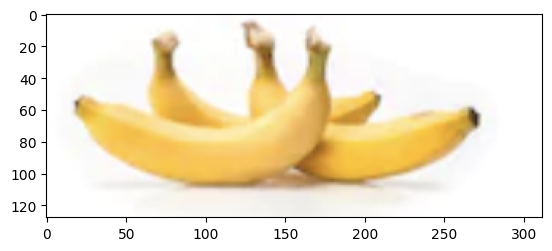

In [ ]:
import matplotlib.pyplot as plt

def show_image(path):
  image = iio.imread(path)
  plt.imshow(image)

sample_min_height = (dataset_df[dataset_df["height"] == dataset_df["height"].min()]).sample(n=1)
image_path = sample_min_height.iloc[0]["path"]
print(sample_min_height)
show_image(image_path)

# Subsets generation

We then split the dataset into the subset we use train/test set. We will be saving 10% of the total of images for validation

In [ ]:
from sklearn.model_selection import train_test_split

train_and_test, validation = train_test_split(dataset_df, test_size=0.1)

And now we save an index for our data, along with other information, by saving the two dataframes as Excel files

In [ ]:
import os
base_folder = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project"
validation.to_excel(os.path.join(base_folder, "validation_set.xlsx"), index=False)
train_and_test.to_excel(os.path.join(base_folder, "train_and_test_set.xlsx"), index=False)